In [6]:
from libraries.db import DatabaseProxy
from bertopic import BERTopic
from hdbscan import HDBSCAN
import dotenv
from bertopic.representation import OpenAI, KeyBERTInspired
import openai
import os
import pandas as pd
import matplotlib.pyplot as plt


In [9]:
# disable deprecated warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [8]:
db = DatabaseProxy(reset=True, database="eda")
dotenv.load_dotenv(".envrc")

False

In [10]:
df = pd.read_csv("input/qa-pairs.csv", encoding="latin-1")
df["id"] = df.index
db.insert_from_dataframe(df, col_questions="question", col_answers="answer")

# Basic Statistics

In [11]:
df.head()

question  \
0  Checking the financial stability of our suppli...   
1  How many candidates do you have in your database?   
2  How do you select which candidates are placed ...   
3  How often do you review and refresh your datab...   
4  What type of background and drug testing do yo...   

                                              answer  \
0  Our fiscal year begins in January and ends in ...   
1  As of today, 4/25/2023, we have the following:...   
2  Our specialized role known as the client speci...   
3  Our sourcing platform is updated throughout th...   
4  AccuSource is our service provider for backgro...   

   partners_personnel_selected  id  
0                            0   0  
1                            0   1  
2                            0   2  
3                            0   3  
4                            0   4

Number of questions

In [12]:
df.shape

(168, 4)

Question length (character and word count)

In [13]:
df["question_length"] = df["question"].apply(len)
df["question_wordcount"] = df["question"].apply(lambda x: len(x.split(" ")))

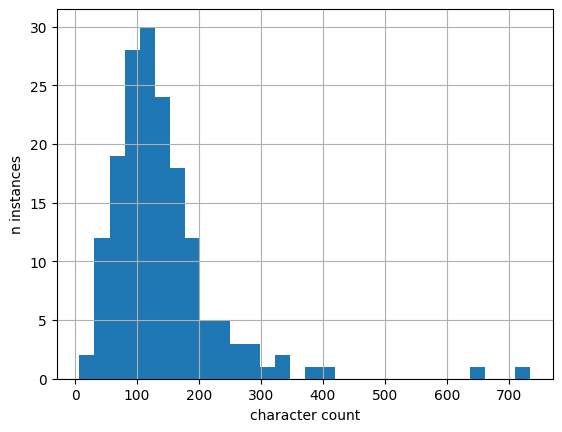

count    168.000000
mean     140.869048
std       91.372539
min        7.000000
25%       91.500000
50%      123.000000
75%      163.750000
max      735.000000
Name: question_length, dtype: float64

In [14]:
df["question_length"].hist(bins=30)
plt.xlabel("character count")
plt.ylabel("n instances")
plt.show()
df["question_length"].describe()

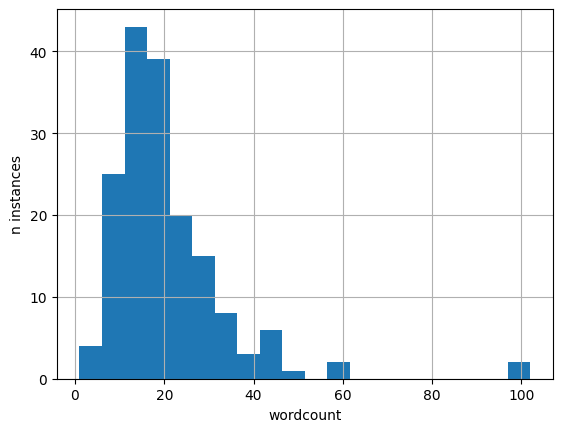

count    168.000000
mean      21.059524
std       13.481725
min        1.000000
25%       14.000000
50%       18.000000
75%       25.000000
max      102.000000
Name: question_wordcount, dtype: float64

In [ ]:
df["question_wordcount"].hist(bins=20)
plt.xlabel("wordcount")
plt.ylabel("n instances")
plt.show()
df["question_wordcount"].describe()

Bundled question distribution

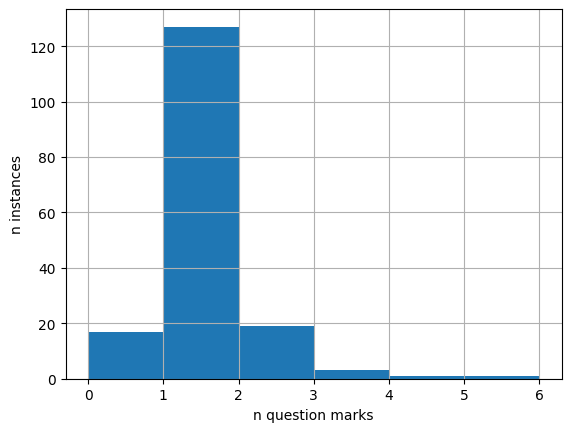

count    168.000000
mean       1.095238
std        0.694185
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        6.000000
Name: n_bundled_questions, dtype: float64

In [ ]:
df["n_bundled_questions"] = df["question"].apply(lambda x: x.count("?"))
df["n_bundled_questions"].hist(bins=6)
plt.xlabel("n question marks")
plt.ylabel("n instances")
plt.show()
df["n_bundled_questions"].describe()

# Named Entity Recognizer

In [ ]:
import spacy
from spacy import displacy

nlp = spacy.load("en_core_web_sm")

In [ ]:
ents = []
for i, row in df.iterrows():
    question = row["question"]
    doc = nlp(question)
    ents.append([ent.lemma_.lower() for ent in doc.ents])
    if i % 16 == 0:
        displacy.render(doc, style="ent", jupyter=True)

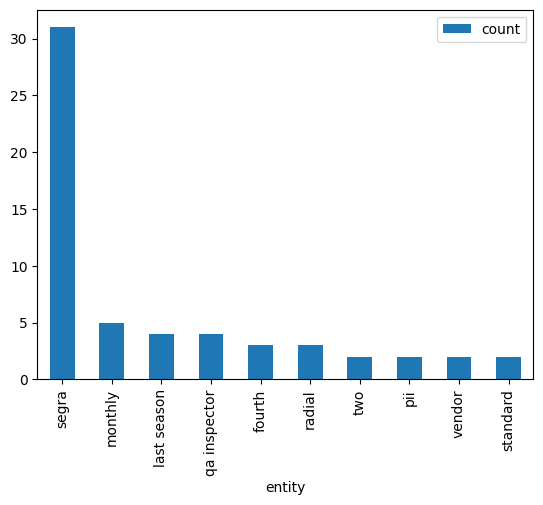

In [ ]:
#bar chart of most common ent

from collections import Counter
from itertools import chain

ents = list(chain.from_iterable(ents))
ent_counts = Counter(ents)
ent_counts.most_common(10)

ent_counts_df = pd.DataFrame(ent_counts.most_common(10), columns=["entity", "count"])
ent_counts_df.plot.bar(x="entity", y="count")
plt.show()

# Topic Modeling

Uses LDA according to the following article: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

Clean data

In [ ]:
# Load the regular expression library
import re

# Remove punctuation
df["question_processed"] = df["question"].map(
    lambda x: re.sub("[,\.!?]", "", x)
)
# Convert the titles to lowercase
df["question_processed"] = df["question_processed"].str.lower()
# remove extraneous whitespace
df["question_processed"] = df["question_processed"].str.strip()
# Print out the first rows of papers
df["question_processed"].head()

0    checking the financial stability of our suppli...
1     how many candidates do you have in your database
2    how do you select which candidates are placed ...
3    how often do you review and refresh your datab...
4    what type of background and drug testing do yo...
Name: question_processed, dtype: object

Prepare data for LDA analysis

In [ ]:
from gensim.utils import simple_preprocess

# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords


stop_words = stopwords.words("english")
stop_words.extend(["from", "subject", "re", "edu", "use"])


def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield (simple_preprocess(str(sentence), deacc=True))


def remove_stopwords(texts):
    return [
        [word for word in simple_preprocess(str(doc)) if word not in stop_words]
        for doc in texts
    ]


data = df["question_processed"].values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['checking', 'financial', 'stability', 'suppliers', 'part', 'due', 'diligence', 'process', 'support', 'us', 'please', 'tell', 'us', 'company', 'financial', 'year', 'runs']


In [ ]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1)]


LDA model training

In [ ]:
import gensim
from pprint import pprint

# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(
    corpus=corpus, id2word=id2word, num_topics=num_topics
)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.018*"data" + 0.016*"segra" + 0.016*"please" + 0.012*"explain" + '
  '0.012*"organization" + 0.011*"information" + 0.010*"changes" + '
  '0.009*"encryption" + 0.008*"place" + 0.007*"access"'),
 (1,
  '0.018*"please" + 0.014*"security" + 0.014*"information" + 0.013*"data" + '
  '0.012*"part" + 0.012*"system" + 0.011*"segra" + 0.010*"vendor" + '
  '0.009*"place" + 0.008*"future"'),
 (2,
  '0.022*"access" + 0.015*"assets" + 0.014*"segra" + 0.014*"provide" + '
  '0.010*"data" + 0.008*"competitors" + 0.008*"criminal" + 0.008*"please" + '
  '0.008*"company" + 0.008*"security"'),
 (3,
  '0.024*"process" + 0.023*"security" + 0.018*"please" + 0.015*"employees" + '
  '0.012*"formal" + 0.012*"documented" + 0.010*"information" + 0.009*"last" + '
  '0.009*"season" + 0.009*"policy"'),
 (4,
  '0.026*"process" + 0.021*"access" + 0.019*"data" + 0.015*"security" + '
  '0.014*"software" + 0.013*"please" + 0.012*"place" + 0.010*"information" + '
  '0.009*"yes" + 0.008*"company"'),
 (5,
  '0.022*"

Analyzing LDA results

In [ ]:
import pyLDAvis.gensim
import pickle
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join("./output/ldavis_prepared_" + str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
with open(LDAvis_data_filepath, "wb") as f:
    pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, "rb") as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(
    LDAvis_prepared, "./output/ldavis_prepared_" + str(num_topics) + ".html"
)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.065368 -0.063204       1        1  19.438169
3     -0.017045 -0.109369       2        1  11.957162
8      0.154162  0.038075       3        1  11.517649
9     -0.067769  0.084670       4        1  10.082910
0     -0.070448  0.073979       5        1   9.936729
2      0.070270  0.000316       6        1   9.688716
4     -0.021428 -0.067652       7        1   9.310112
1      0.039419 -0.037531       8        1   6.708051
5     -0.008352  0.034739       9        1   6.514612
6     -0.013441  0.045977      10        1   4.845890, topic_info=            Term       Freq      Total Category  logprob  loglift
7        process  20.000000  20.000000  Default  30.0000  30.0000
589        media   5.000000   5.000000  Default  29.0000  29.0000
211       access  22.000000  22.000000  Default  28.0000  28.0000
86   information  13.000000  13.000000  Default  27.0000  27.0000
234     security  26.000000  26.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
349          new   0.563328   3.323622  Topic10  -5.2131   1.2521
175   management   0.563327   7.596275  Topic10  -5.2131   0.4255
154          non   0.563326   4.931445  Topic10  -5.2131   0.8575
82           yes   0.563323  11.474070  Topic10  -5.2131   0.0130
211       access   0.563323  22.904176  Topic10  -5.2131  -0.6782

[617 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
549       4  0.675117  acceptable
170       3  0.412881  acceptance
170       8  0.412881  acceptance
211       1  0.305621      access
211       2  0.043660      access
...     ...       ...         ...
82        4  0.174306         yes
82        7  0.174306         yes
82        9  0.174306         yes
82       10  0.087153         yes
527       1  0.668600        zone

[853 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 9, 10, 1, 3, 5, 2, 6, 7])

# Word Frequency Analysis

/Users/kalebsmith/ownCloud/school/cs-482/Partners-Personnel-Capstone-Project/.venv/lib/python3.11/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


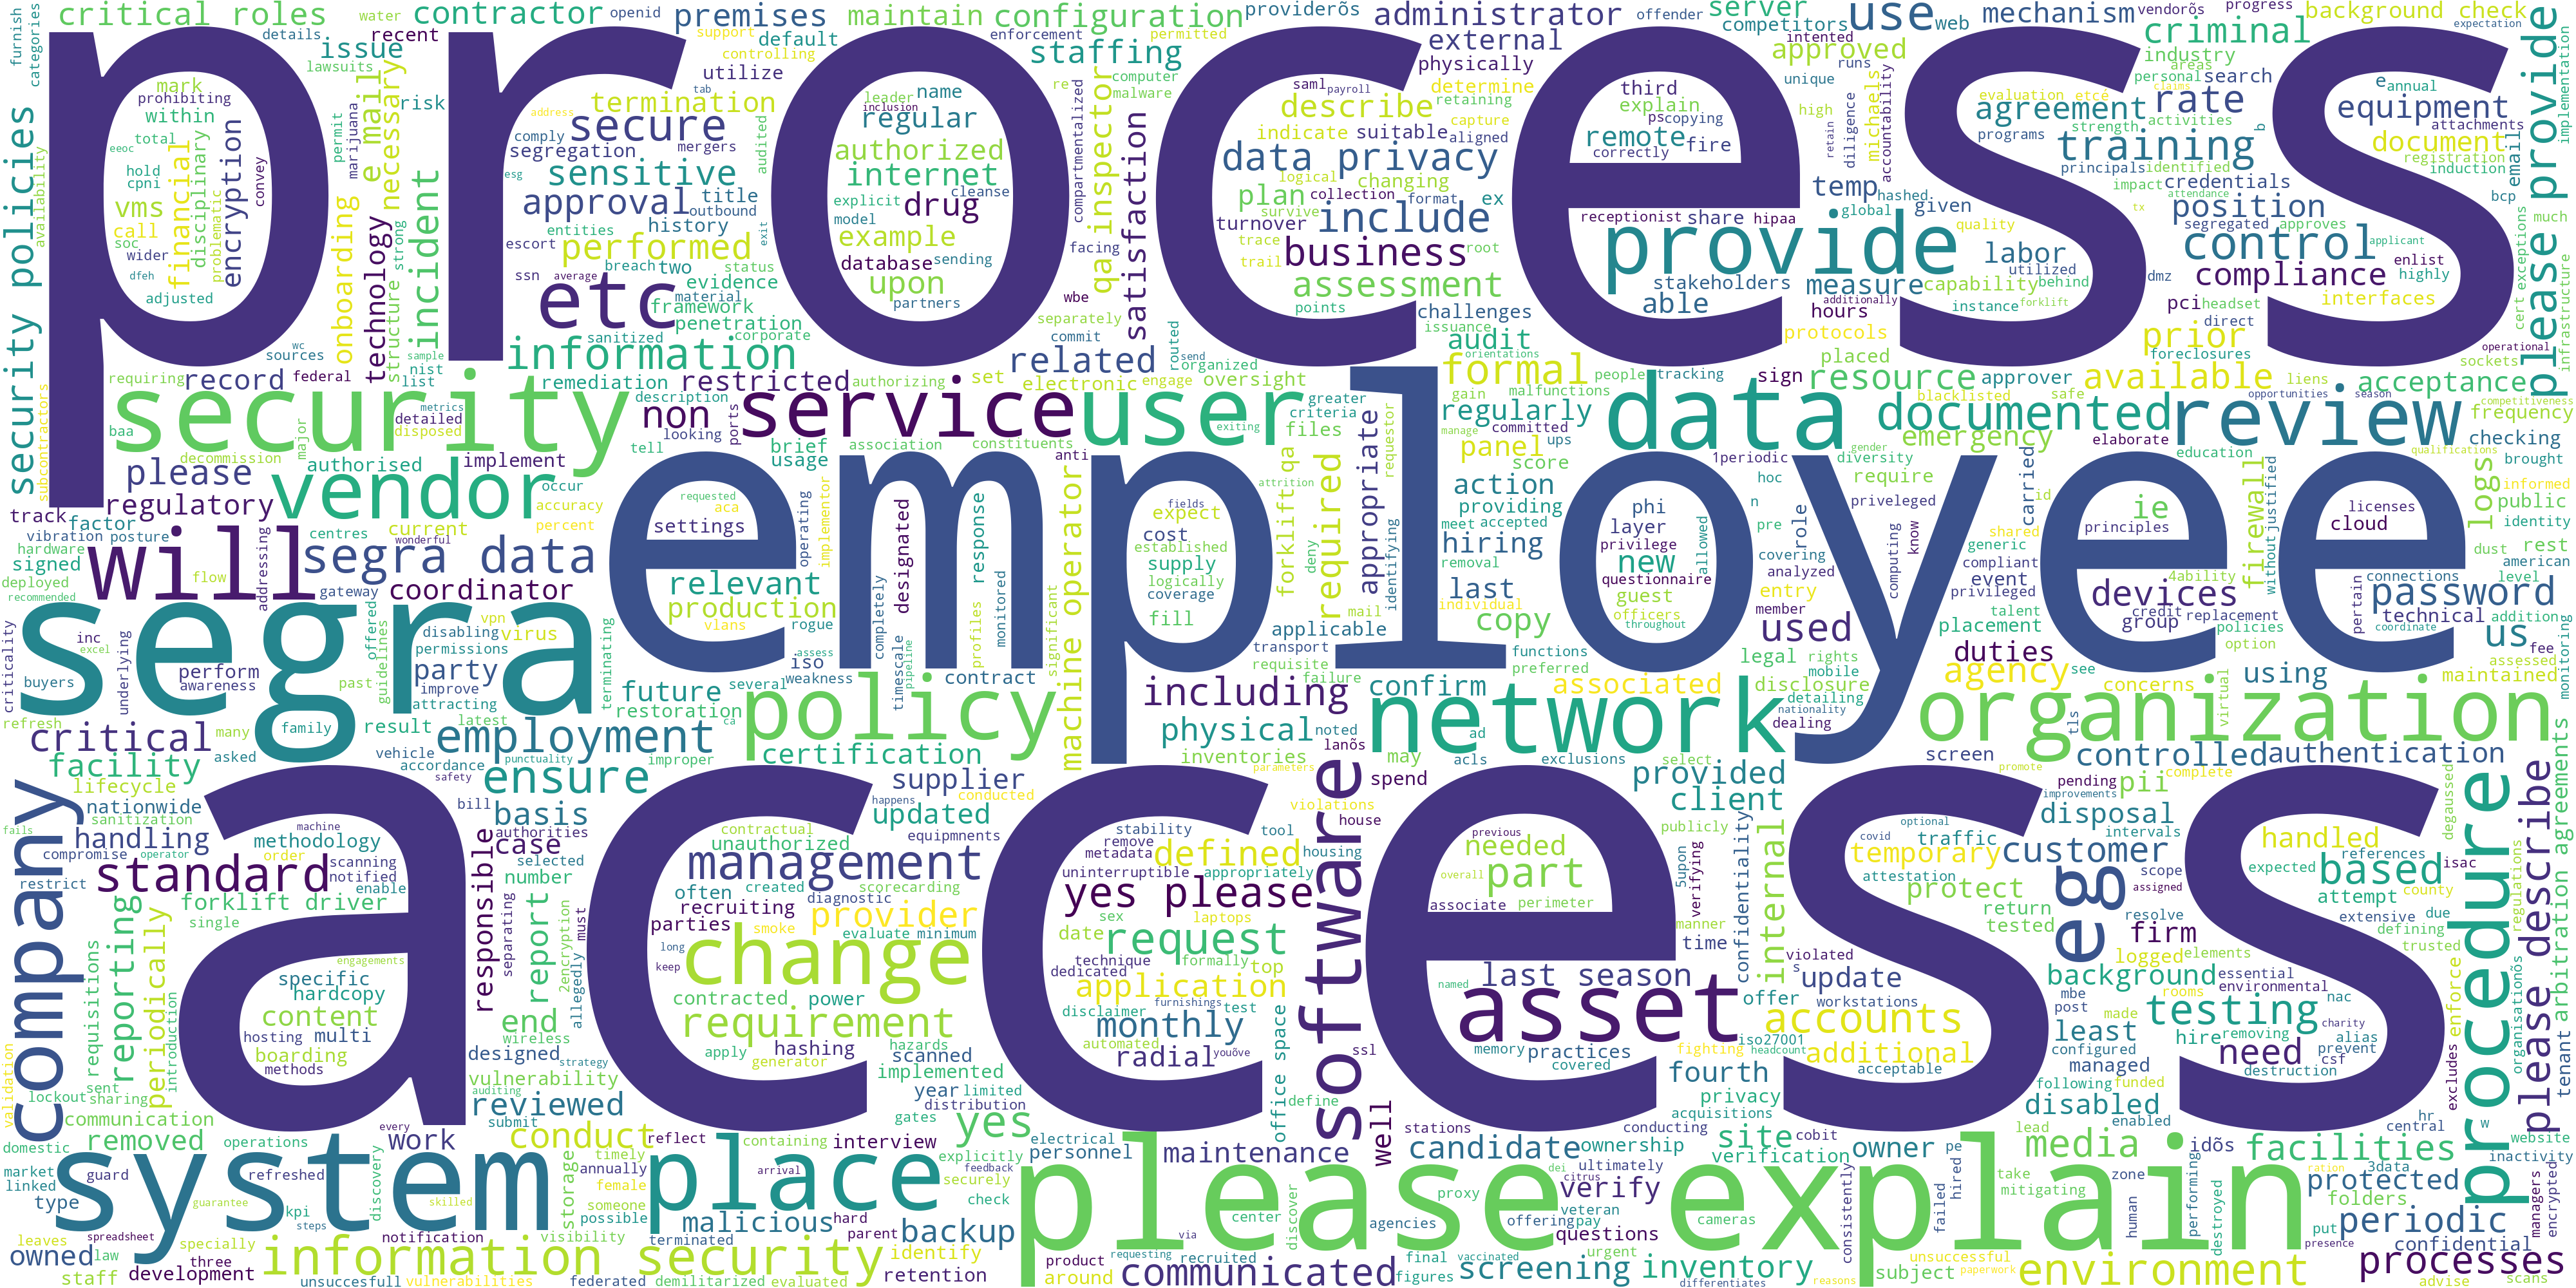

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ",".join(list(df["question_processed"].values))
# Create a WordCloud object
wordcloud = WordCloud(
    background_color="white",
    width=4000,
    height=2000,
    max_words=5000,
    contour_width=3,
    contour_color="steelblue",
)
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

# Vocabulary Size

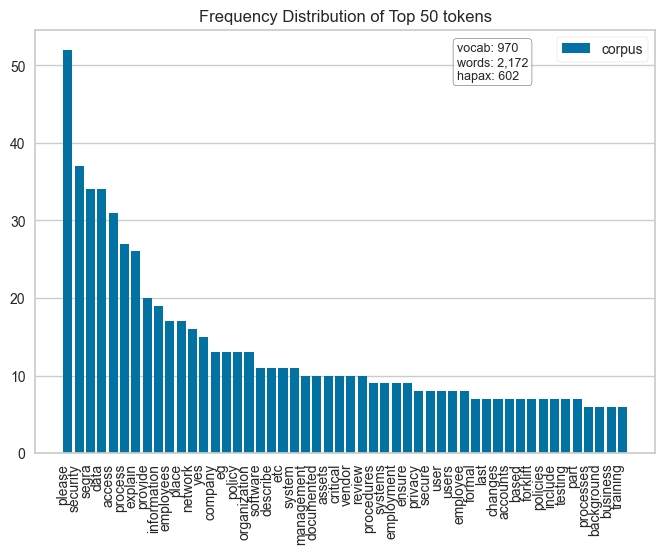

<Axes: title={'center': 'Frequency Distribution of Top 50 tokens'}>

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer

vectorizer = CountVectorizer()
questions_text = df["question_processed"]
# remove stop words
questions_text = questions_text.apply(
    lambda x: " ".join([word for word in x.split() if word not in (stop_words)])
)
docs = vectorizer.fit_transform(questions_text)

features = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient="v")
visualizer.fit(docs)
visualizer.show()

# Duplicate / Similar Questions

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df["question_processed"])
cosine_similarities = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
pd.DataFrame(cosine_similarities).to_csv("output/cosine_similarities_tfidf.csv")

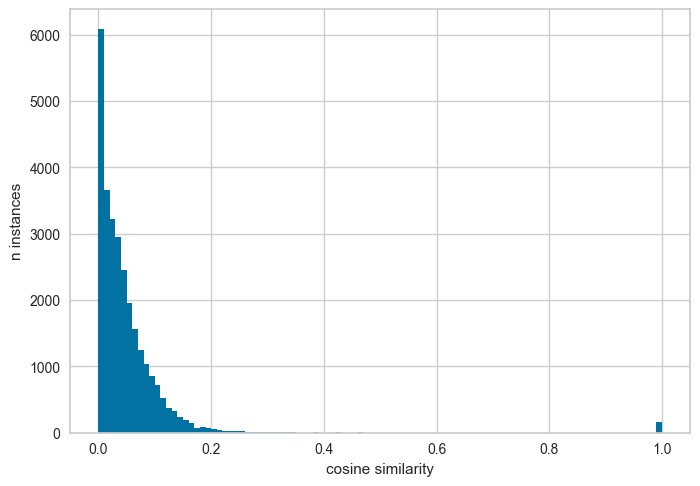

In [ ]:
# distribution of cosine similarities
plt.hist(cosine_similarities.flatten(), bins=100)
plt.xlabel("cosine similarity")
plt.ylabel("n instances")
plt.show()

In [ ]:
results = set()  # list of tuple pairs where (id1, id2)
for idx1, row1 in df.iterrows():
    for idx2, row2 in df.iterrows():
        if idx1 == idx2:
            continue
        sim = cosine_similarities[idx1, idx2]
        if sim < 0.3:
            continue
        results.add((idx1, idx2) if idx1 < idx2 else (idx2, idx1))

len(results), list(results)[:10]

(32,
 [(55, 148),
  (152, 166),
  (1, 3),
  (109, 110),
  (155, 156),
  (2, 8),
  (31, 53),
  (49, 71),
  (45, 58),
  (119, 120)])

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

embeddings = model.encode(df["question_processed"], convert_to_tensor=True)
cosine_similarities = cosine_similarity(embeddings, embeddings)

In [ ]:
pd.DataFrame(cosine_similarities).to_csv("output/cosine_similarities_sentencetransformers.csv")

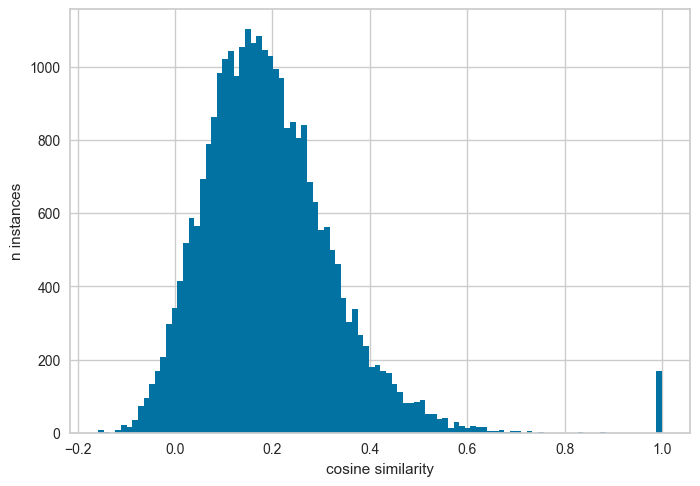

In [ ]:
# distribution of cosine similarities
plt.hist(cosine_similarities.flatten(), bins=100)
plt.xlabel("cosine similarity")
plt.ylabel("n instances")
plt.show()

In [ ]:
std = cosine_similarities.std()
mean = cosine_similarities.mean()

In [ ]:
for idx1, row1 in df.iterrows():
    for idx2, row2 in df.iterrows():
        if idx1 == idx2:
            continue
        sim = cosine_similarities[idx1, idx2]
        if sim < mean + 3 * std:
            continue
        results.add((idx1, idx2) if idx1 < idx2 else (idx2, idx1))

len(results), list(results)[:10]

(66,
 [(91, 111),
  (164, 165),
  (108, 118),
  (31, 32),
  (55, 148),
  (25, 108),
  (71, 108),
  (121, 124),
  (152, 166),
  (1, 3)])

In [ ]:
with open("output/results.txt", "w") as f:
    for idx1, idx2 in results:
        f.write(f"1 {df.iloc[idx1]['question']}\n")
        f.write(f"2 {df.iloc[idx2]['question']}\n")
        f.write("-" * 80 + "\n")

NameError: name 'results' is not defined

# bertopic

In [15]:
questions = [q.text for q in db.get_questions()]

In [16]:
questions[:5]

['Checking the financial stability of our suppliers is part of our due diligence process. To support us in doing this, please tell us when your company financial year runs to and from.',
 'How many candidates do you have in your database?',
 'How do you select which candidates are placed where?  For instance, if two buyers are looking for the same candidate, how do you ultimately determine which company to place that employee with?',
 'How often do you review and refresh your database of candidates?',
 'What type of background and drug testing do you conduct?  How extensive are they? Who is your service provider for background checking?']

In [28]:
# Fine-tune topic representations with GPT
representation_model = KeyBERTInspired()
topic_model = BERTopic(representation_model=representation_model)
topics, probs = topic_model.fit_transform(questions)

## HDBSCAN

In [40]:
hdbscan_model = HDBSCAN(min_cluster_size=3, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
topic_model = BERTopic(hdbscan_model=hdbscan_model)
topics, probs = topic_model.fit_transform(questions)

In [42]:
topic_model.get_topic_info()

Topic  Count                                    Name  \
0      -1     30                  -1_the_is_software_for   
1       0     31                     0_access_are_to_and   
2       1     28                      1_segra_to_of_data   
3       2     27                      2_you_your_what_do   
4       3      7       3_criminal_background_drug_checks   
5       4      7          4_termination_there_or_process   
6       5      7               5_email_user_accounts_ids   
7       6      6                  6_any_ownership_are_or   
8       7      6             7_privacy_data_and_security   
9       8      6  8_policies_security_review_development   
10      9      5     9_information_does_include_security   
11     10      4       10_fire_such_environmental_latest   
12     11      4   11_assets_asset_inventory_inventories   

                                       Representation  \
0   [the, is, software, for, and, security, to, do...   
1   [access, are, to, and, the, there, system, onl...   
2   [segra, to, of, data, and, from, be, please, w...   
3   [you, your, what, do, critical, how, forklift,...   
4   [criminal, background, drug, checks, screening...   
5   [termination, there, or, process, employment, ...   
6   [email, user, accounts, ids, there, password, ...   
7   [any, ownership, are, or, company, in, wc, gre...   
8   [privacy, data, and, security, assessment, com...   
9   [policies, security, review, development, and,...   
10  [information, does, include, security, the, su...   
11  [fire, such, environmental, latest, smoke, haz...   
12  [assets, asset, inventory, inventories, update...   

                                  Representative_Docs  
0   [Is there internal and public notification pro...  
1   [Is access to diagnostic or maintenance ports ...  
2   [For our CA facilities an on-site coordinator ...  
3   [If you were a provider of ours last season wh...  
4   [What type of background and drug testing do y...  
5   [Is there procedures in place for handling sec...  
6   [Is there an Email security policy to define s...  
7   [Any previous legal cases with where both your...  
8   [Is there a formal and well defined security a...  
9   [Is a complete set of your organisationÕs secu...  
10  [Are any information security duties which sur...  
11  [Is there a process to track assessed security...  
12  [Is an Automated asset inventory discovery too...

In [43]:
for _, row in topic_model.get_topic_info().iterrows():
    print(row["Name"], row["Count"])
    for doc in row["Representative_Docs"]:
        print(f"\t-{doc.strip()}")
    print()

-1_the_is_software_for 30
	-Is there internal and public notification procedures in place for reporting data security and privacy related incidents to appropriate authorities and stakeholders (e.g., ES-ISAC, US-CERT, law enforcement, business partners, customers, etc.) in the event of an incident?
	-What is your process for auditing employee onboarding paperwork to ensure arbitration agreements are signed?
Where do you maintain the arbitration agreements and for how long? 
What is the process for requesting the documents if/when needed?
	-What training and recruiting software do you use? Does your offer include access to VMS software? If so, what software? Is usage of this software optional, recommended, or required?

0_access_are_to_and 31
	-Is access to diagnostic or maintenance ports on network devices restricted to users with authorized credentials and only from trusted sources?
	-Are there any default accounts (e.g., "Administrator", root, and generic guest/system accounts) for sy